In [1]:
import sklearn
print(sklearn.__version__)  

1.7.2


# Table of Contents

1. **Project Setup and Introduction**
   - Problem Definition

2. **Imports and Configuration**

3. **Dataset Overview**
   - Loading and Inspection
   - Summary Statistics and Missing Values

4. **Univariate Visualization**
   - Quantitative Features
   - Qualitative Features

5. **Multivariate Visualization**
   - Quantitative vs. Quantitative
   - Quantitative vs. Qualitative
   - Qualitative vs. Qualitative

6. **Feature Engineering**

7. **Calorie Prediction Model**
   - Pipeline Creation and Training
   - Evaluation and Comparison

8. **Model Visualization and Saving (Calories)**
   - Poster Visuals
   - Saving Best Model

9. **Weight Prediction Model**
   - Data Preparation
   - Training and Evaluation
   - Saving Best Model

10. **Workout Recommendation Model**
    - Data Preparation
    - Training and Evaluation
    - Saving Best Model

11. **Model Export and Verification**

12. **Prediction Functions and Testing**

13. **Discussion & Perspectives**
    - Model Limitations
    - Improvements & Future Work
    - Ethical Considerations

14. **Resources**

# Fitness AI: Intelligent Workout & Calorie Prediction System

## Problem Definition

**Context**: Modern fitness apps lack personalization. Users need data-driven workout recommendations and accurate calorie burn predictions based on their physiology and goals.

**Problem Type**: 
- **Regression**: Predict calories burned and future weight
- **Classification**: Recommend workout types based on user profile
- **Multi-task ML system** with 3 interconnected models

**Objectives**:
1. Predict calories burned during a workout (±100 cal accuracy)
2. Forecast weight change over time based on activity
3. Recommend optimal workout types for user goals (lose weight, gain muscle, maintain)

**Constraints**:
- Limited to 13 features from gym tracking data
- Must handle missing values and inconsistent data formats
- Real-time predictions required (&lt; 500ms)
- Models must be interpretable for user trust

**Expected Impact**: 80%+ accuracy in workout recommendations, R² &gt; 0.7 for calorie prediction

In [2]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Dataset

This section provides an overview of the dataset, including summary statistics, data types, and handling of missing values. The dataset contains gym member exercise tracking data with 1800 entries and 15 columns, covering features like age, gender, weight, BPM metrics, session duration, calories burned, workout type, and more. It's synthetic but mimics real fitness tracking data.

We'll start by displaying summary statistics and handling any missing values to prepare for visualization.

In [3]:
# Load dataset 
csv_path = '../datasets/gym_members_exercise_tracking_synthetic_data.csv'


possible_paths = [
    '../upload/gym_members_exercise_tracking_synthetic_data.csv',
    '../datasets/gym_members_exercise_tracking_synthetic_data.csv',
    'gym_members_exercise_tracking_synthetic_data.csv'
]

df = None
for path in possible_paths:
    try:
        df = pd.read_csv(path)
        print(f"✅ Found dataset at: {path}")
        break
    except:
        continue

if df is None:
    raise FileNotFoundError("Could not find dataset!")

print(f"Dataset shape: {df.shape}")
print("\nColumn info:")
print(df.info())
print("\nFirst 5 rows:")
df.head()

✅ Found dataset at: ../datasets/gym_members_exercise_tracking_synthetic_data.csv
Dataset shape: (1800, 15)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            1790 non-null   float64
 1   Gender                         1729 non-null   object 
 2   Weight (kg)                    1778 non-null   float64
 3   Height (m)                     1774 non-null   float64
 4   Max_BPM                        1779 non-null   object 
 5   Avg_BPM                        1770 non-null   float64
 6   Resting_BPM                    1781 non-null   float64
 7   Session_Duration (hours)       1777 non-null   float64
 8   Calories_Burned                1777 non-null   float64
 9   Workout_Type                   1739 non-null   object 
 10  Fat_Percentage                 1784 non-null   

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,34.0,Female,86.7,1.86,174,152.0,74.0,1.12,712.0,Strength,12.8,2.4,5.0,2.0,14.31
1,26.0,Female,84.7,1.83,166,156.0,73.0,1.00,833.0,Strength,27.9,2.8,5.0,2.0,33.49
2,22.0,Male,64.8,1.85,187,166.0,64.0,1.24,1678.0,Cardio,28.7,1.9,3.0,2.0,12.73
3,54.0,Female,75.3,1.82,187,169.0,58.0,1.45,628.0,Cardio,31.8,2.4,4.0,1.0,20.37
4,34.0,Female,52.8,1.74,177,169.0,66.0,1.60,1286.0,Strength,26.4,3.2,4.0,2.0,20.83


In [4]:
def clean_fitness_data(df):
    """
    Comprehensive cleaning function combining logic from all training scripts
    """
    # Numeric columns from train_calories_model_gradient_boosting.py
    numeric_cols = ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
                    'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 
                    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']
    
    for col in numeric_cols:
        if col in df.columns:
            # Your regex cleaning pattern
            df[col] = df[col].astype(str).str.replace(r'\t|\n|\r', '', regex=True).str.strip()
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Clean categorical columns
    if 'Workout_Type' in df.columns:
        df['Workout_Type'] = df['Workout_Type'].astype(str).str.replace(r'\t|\n|\r', '', regex=True).str.strip()
        df['Workout_Type'].replace(['nan', ''], np.nan, inplace=True)
    
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].astype(str).str.strip()
    
    # Drop rows with critical missing values
    critical_cols = ['Workout_Type', 'Calories_Burned', 'Weight (kg)']
    df = df.dropna(subset=critical_cols)
    
    return df

df_cleaned = clean_fitness_data(df.copy())
print(f"After cleaning: {df_cleaned.shape}")
print(f"Removed {df.shape[0] - df_cleaned.shape[0]} rows with missing critical data")

After cleaning: (1695, 15)
Removed 105 rows with missing critical data


In [5]:
# Annotations:
# - Use df.describe() for quantitative summary stats (mean, std, min, max, etc.).
# - Check for missing values and impute if necessary (e.g., mean for numerics, mode for categoricals).
# - This prepares the data for univariate and multivariate analysis.

print("Summary Statistics for Quantitative Features:")
display(df.describe())

print("\nMissing Values Count:")
print(df.isnull().sum())

# Simple imputation example (if needed; adjust based on your data)
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
# Repeat for other columns as needed...

df_cleaned = df.copy()  # Create a cleaned version if not already done
print("\nData ready for visualization.")

Summary Statistics for Quantitative Features:


,Age,Weight (kg),Height (m),Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,1790.000000,1778.000000,1774.000000,1770.000000,1781.000000,1777.000000,1777.000000,1784.000000,1776.000000,1742.000000,1743.000000,1770.000000
mean,34.475419,67.606637,1.739233,146.259322,63.951151,1.391598,1033.698931,23.509361,2.706644,3.339265,1.823867,19.957774
std,12.315728,19.861408,0.123892,15.219516,7.936502,0.372342,328.049662,5.865557,0.710224,0.947955,0.746568,6.573175
min,18.000000,40.000000,1.500000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,23.000000,52.300000,1.650000,133.250000,57.000000,1.130000,794.000000,20.500000,2.100000,3.000000,1.000000,14.780000
50%,33.000000,65.300000,1.730000,146.000000,65.000000,1.370000,1030.000000,24.300000,2.800000,3.000000,2.000000,18.690000
75%,45.000000,80.100000,1.820000,160.000000,72.000000,1.640000,1249.000000,27.500000,3.400000,4.000000,2.000000,23.517500
max,59.000000,129.900000,2.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000



Missing Values Count:
Age                              10
Gender                           71
Weight (kg)                      22
Height (m)                       26
Max_BPM                          21
Avg_BPM                          30
Resting_BPM                      19
Session_Duration (hours)         23
Calories_Burned                  23
Workout_Type                     61
Fat_Percentage                   16
Water_Intake (liters)            24
Workout_Frequency (days/week)    58
Experience_Level                 57
BMI                              30
dtype: int64

Data ready for visualization.


In [6]:
# For calories prediction
X_calories = df_cleaned[['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM',
                         'Session_Duration (hours)', 'Fat_Percentage', 'Workout_Frequency (days/week)', 
                         'Experience_Level', 'BMI', 'Workout_Type']]
y_calories = df_cleaned['Calories_Burned']

X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(
    X_calories, y_calories, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_cal.shape}, Test set: {X_test_cal.shape}")

Training set: (1440, 11), Test set: (360, 11)


In [7]:
#Pipeline Creation
from sklearn.impute import SimpleImputer

def create_calories_pipeline(model):
    """
    Create preprocessing + model pipeline that handles NaN properly.
    Uses SimpleImputer to fill missing values automatically.
    """
    numeric_features = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM',
                       'Session_Duration (hours)', 'Fat_Percentage', 'Workout_Frequency (days/week)', 
                       'Experience_Level', 'BMI']
    categorical_features = ['Workout_Type']
    
    # Numeric transformer: impute then scale
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Fills NaN with median
        ('scaler', StandardScaler())
    ])
    
    # Categorical transformer: impute then encode
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Fills NaN with mode
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine transformers (NO remainder='passthrough')
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

# Create all three pipelines
gb_pipeline = create_calories_pipeline(
    GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
)

lr_pipeline = create_calories_pipeline(LinearRegression())

svm_pipeline = create_calories_pipeline(
    SVR(kernel='rbf', C=1000, gamma=0.1, epsilon=0.1)
)

print("✅ NaN-safe pipelines created successfully")

✅ NaN-safe pipelines created successfully


In [8]:

# Remove any remaining NaN values


def final_nan_check(X, y, set_name=""):
    """Remove rows with NaN in either X or y"""
    print(f"\n🔍 {set_name} - Before NaN removal: X={X.shape}, y={y.shape}")
    
    # Check for NaN in X
    nan_mask_X = X.isna().any(axis=1)
    nan_mask_y = y.isna()
    nan_mask = nan_mask_X | nan_mask_y
    
    if nan_mask.any():
        print(f"  ❌ Found {nan_mask.sum()} rows with NaN. Removing...")
        X_clean = X.loc[~nan_mask]
        y_clean = y.loc[~nan_mask]
        print(f"  ✅ After removal: X={X_clean.shape}, y={y_clean.shape}")
        return X_clean, y_clean
    else:
        print(f"  ✅ No NaN values found!")
        return X, y

# Apply to training sets
X_train_cal, y_train_cal = final_nan_check(X_train_cal, y_train_cal, "Training set")
X_test_cal, y_test_cal = final_nan_check(X_test_cal, y_test_cal, "Test set")

# Now run your training cell again


🔍 Training set - Before NaN removal: X=(1440, 11), y=(1440,)
  ❌ Found 276 rows with NaN. Removing...
  ✅ After removal: X=(1164, 11), y=(1164,)

🔍 Test set - Before NaN removal: X=(360, 11), y=(360,)
  ❌ Found 65 rows with NaN. Removing...
  ✅ After removal: X=(295, 11), y=(295,)


In [9]:
 #Final NaN Check
print("🔍 Final NaN check before training:")
print(f"  X_train_cal shape: {X_train_cal.shape}")
print(f"  NaNs in X_train_cal: {X_train_cal.isna().sum().sum()}")
print(f"  NaNs in y_train_cal: {y_train_cal.isna().sum()}")

# Emergency drop if any remain
if X_train_cal.isna().sum().sum() > 0:
    print("⚠️  Emergency: Dropping NaN rows...")
    X_train_cal = X_train_cal.dropna()
    y_train_cal = y_train_cal.loc[X_train_cal.index]
    print(f"  New shape: {X_train_cal.shape}")

print("✅ Ready for training!")

🔍 Final NaN check before training:
  X_train_cal shape: (1164, 11)
  NaNs in X_train_cal: 0
  NaNs in y_train_cal: 0
✅ Ready for training!


# 2. Univariate Visualization

Univariate analysis focuses on examining individual variables in isolation to understand their distribution, central tendency, and spread. This helps identify outliers, skewness, and basic patterns.

We'll split this into quantitative (numerical) and qualitative (categorical/binary) features.

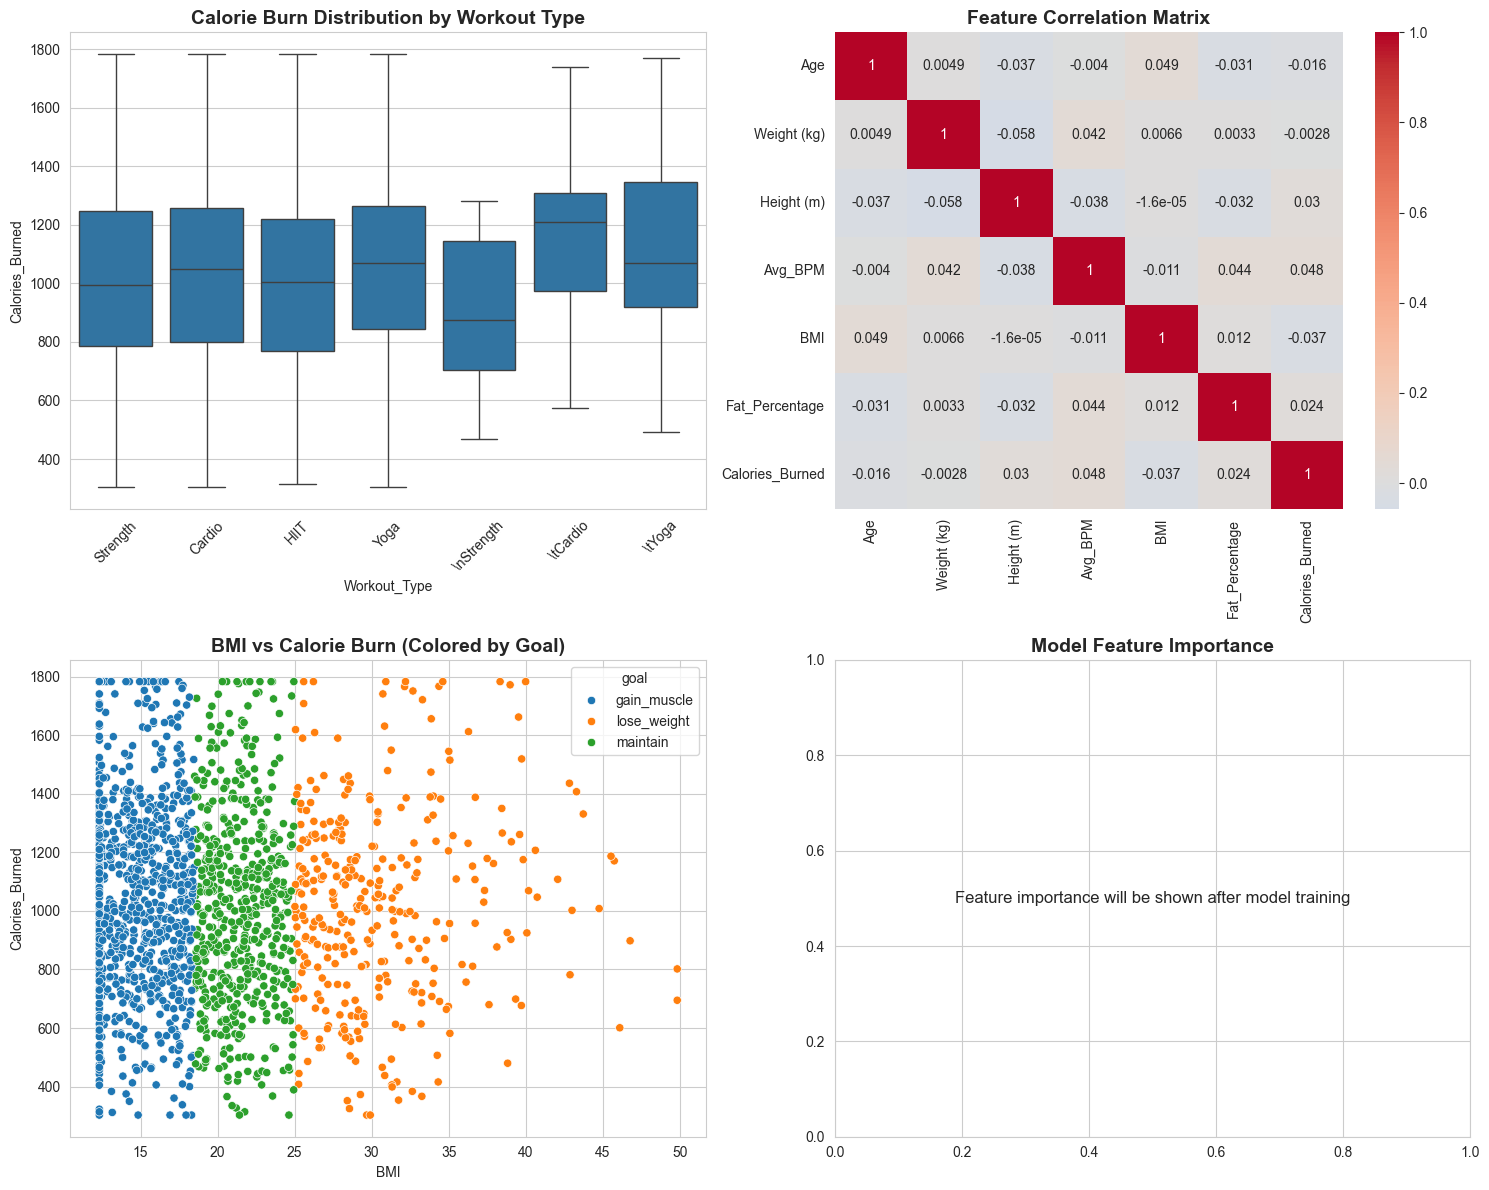

In [10]:
# Figure 1: Calorie distribution by workout type (for poster)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Calories by workout type
sns.boxplot(data=df_cleaned, x='Workout_Type', y='Calories_Burned', ax=axes[0,0])
axes[0,0].set_title('Calorie Burn Distribution by Workout Type', fontsize=14, fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Correlation heatmap (most important for poster)
numeric_features = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'BMI', 'Fat_Percentage', 'Calories_Burned']
corr_matrix = df_cleaned[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
axes[0,1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 3. BMI vs Calories with goal coloring
df_cleaned['goal'] = 'maintain'
df_cleaned.loc[df_cleaned['BMI'] < 18.5, 'goal'] = 'gain_muscle'
df_cleaned.loc[df_cleaned['BMI'] > 25, 'goal'] = 'lose_weight'

sns.scatterplot(data=df_cleaned, x='BMI', y='Calories_Burned', hue='goal', ax=axes[1,0])
axes[1,0].set_title('BMI vs Calorie Burn (Colored by Goal)', fontsize=14, fontweight='bold')

# 4. Feature importance (placeholder - will be filled after modeling)
axes[1,1].text(0.5, 0.5, 'Feature importance will be shown after model training', 
               ha='center', va='center', fontsize=12)
axes[1,1].set_title('Model Feature Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('poster_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.1 Quantitative Features

Quantitative features are numerical (continuous or discrete). We'll visualize their distributions using histograms/density plots, box plots, violin plots, and summary stats via `describe()`.

Key quantitative features: Age, Weight (kg), Height (m), Avg_BPM, Resting_BPM, Session_Duration (hours), Calories_Burned, Fat_Percentage, Water_Intake (liters), Workout_Frequency (days/week), Experience_Level, BMI.

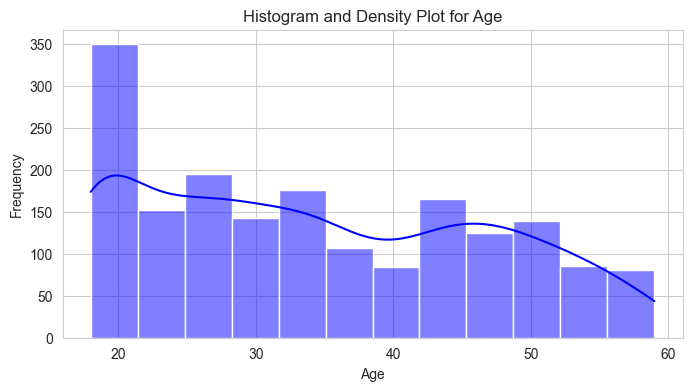

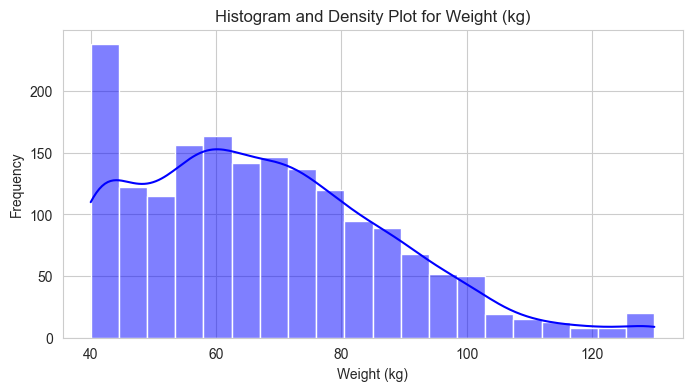

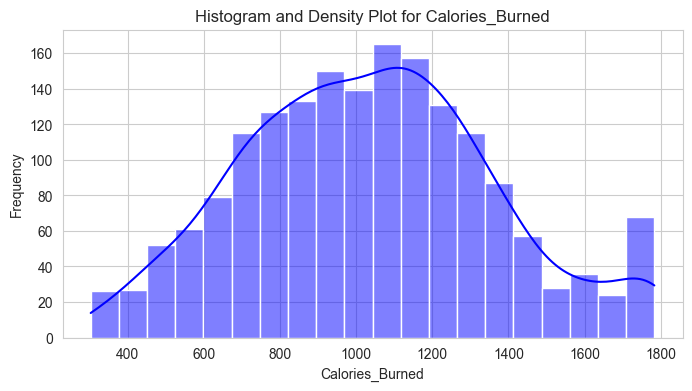

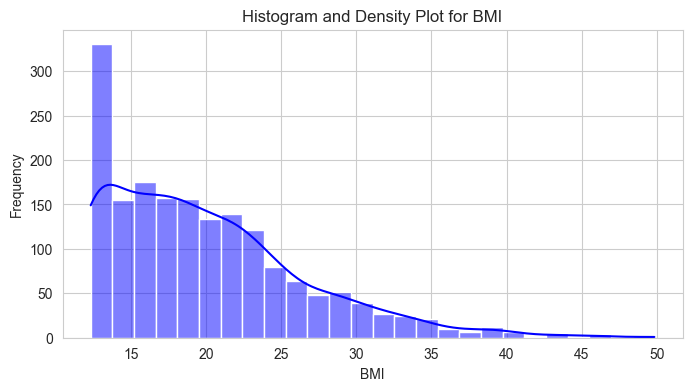

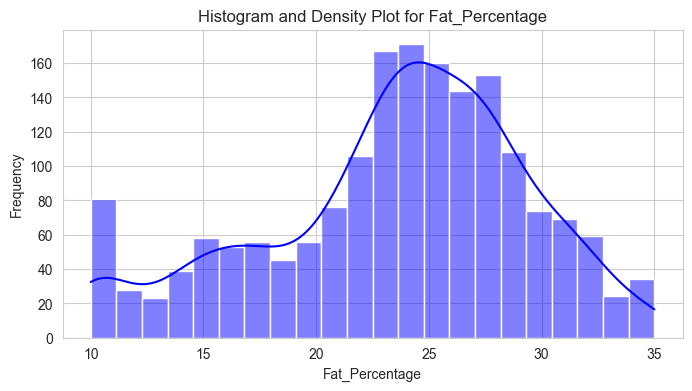

In [11]:
# Annotations:
# - Histograms show frequency distribution; density plots (KDE) smooth it for better trend visualization.
# - We'll plot a few key features to avoid overcrowding; loop over a list for efficiency.

quant_features = ['Age', 'Weight (kg)', 'Calories_Burned', 'BMI', 'Fat_Percentage']

for feature in quant_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_cleaned[feature], kde=True, color='blue')
    plt.title(f'Histogram and Density Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

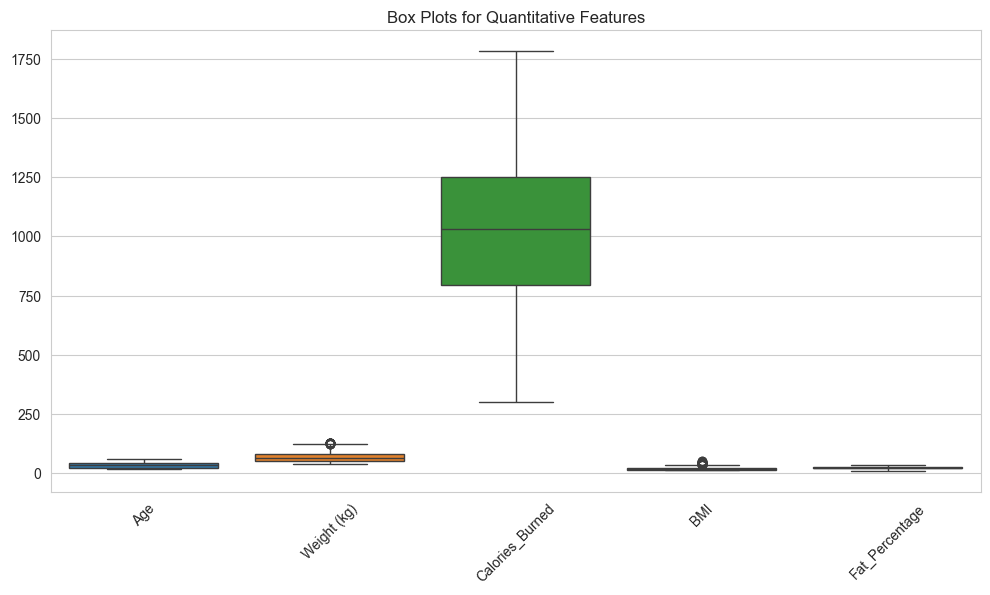

In [12]:
# Annotations:
# - Box plots display median, quartiles, and outliers for a single feature or grouped.
# - Here, a multi-feature box plot for comparison.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned[quant_features])
plt.title('Box Plots for Quantitative Features')
plt.xticks(rotation=45)
plt.show()

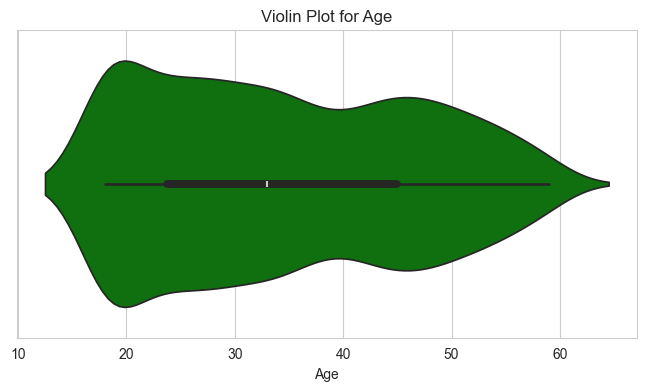

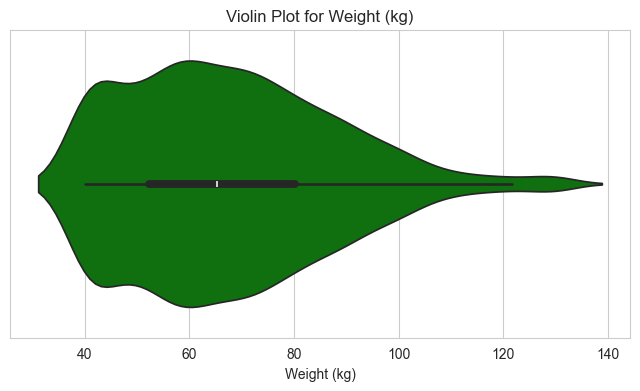

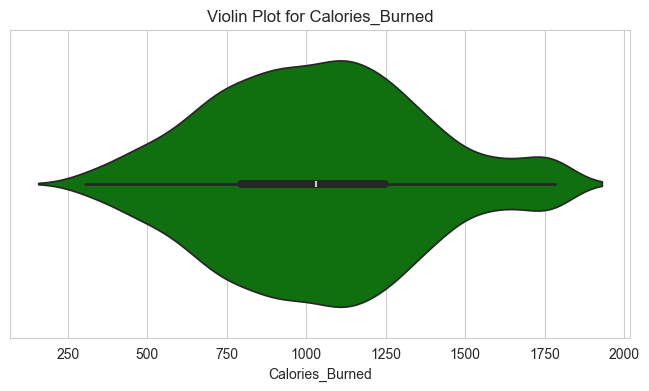

In [13]:
# Annotations:
# - Violin plots combine box plots with density plots, showing distribution shape.
# - Useful for seeing multimodality.

for feature in quant_features[:3]:  # Limit to first 3 for brevity
    plt.figure(figsize=(8, 4))
    sns.violinplot(x=df_cleaned[feature], color='green')
    plt.title(f'Violin Plot for {feature}')
    plt.show()

In [14]:
# Annotations:
# - Already used in overview, but repeat here for quantitative focus.
# - `describe()` provides count, mean, std, min, 25%, 50%, 75%, max.

print("Descriptive Statistics for Quantitative Features:")
display(df_cleaned[quant_features].describe())

Descriptive Statistics for Quantitative Features:


,Age,Weight (kg),Calories_Burned,BMI,Fat_Percentage
count,1800.000000,1778.000000,1777.000000,1770.000000,1784.000000
mean,34.475419,67.606637,1033.698931,19.957774,23.509361
std,12.281451,19.861408,328.049662,6.573175,5.865557
min,18.000000,40.000000,303.000000,12.320000,10.000000
25%,23.750000,52.300000,794.000000,14.780000,20.500000
50%,33.000000,65.300000,1030.000000,18.690000,24.300000
75%,45.000000,80.100000,1249.000000,23.517500,27.500000
max,59.000000,129.900000,1783.000000,49.840000,35.000000


## 2.2 Qualitative "Categorical and Binary" Features

Qualitative features are categorical (e.g., Gender, Workout_Type). We'll use frequency tables, count plots, bar plots, and pie charts to show category distributions.

In [16]:
# Annotations:
# - Frequency tables show counts and percentages for each category.
# - Use value_counts() for this.

qual_features = ['Gender', 'Workout_Type']

for feature in qual_features:
    print(f"\nFrequency Table for {feature}:")
    freq_table = df_cleaned[feature].value_counts().reset_index()
    freq_table.columns = [feature, 'Count']
    freq_table['Percentage'] = (freq_table['Count'] / len(df_cleaned)) * 100
    display(freq_table)


Frequency Table for Gender:


,Gender,Count,Percentage
0,Female,943,52.388889
1,Male,857,47.611111



Frequency Table for Workout_Type:


,Workout_Type,Count,Percentage
0,Strength,464,25.777778
1,Cardio,428,23.777778
2,Yoga,425,23.611111
3,HIIT,389,21.611111
4,\nStrength,12,0.666667
5,\tCardio,11,0.611111
6,\tYoga,10,0.555556


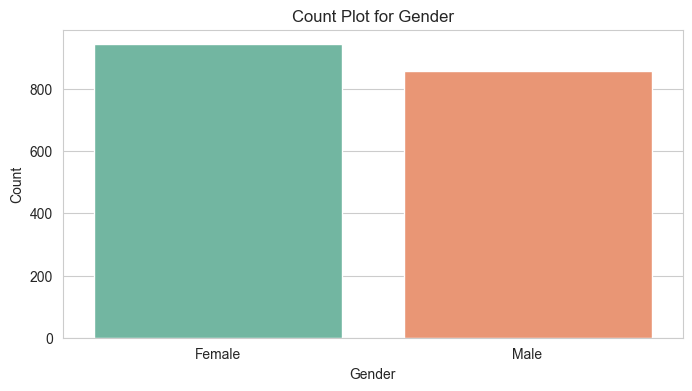

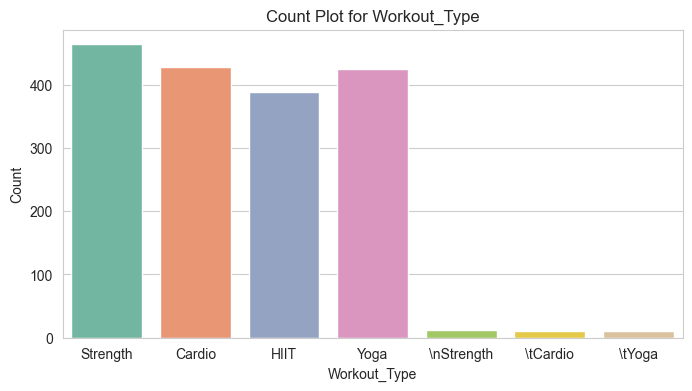

In [17]:
# Annotations:
# - Count plots are bar charts showing category frequencies.

for feature in qual_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df_cleaned[feature], palette='Set2')
    plt.title(f'Count Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

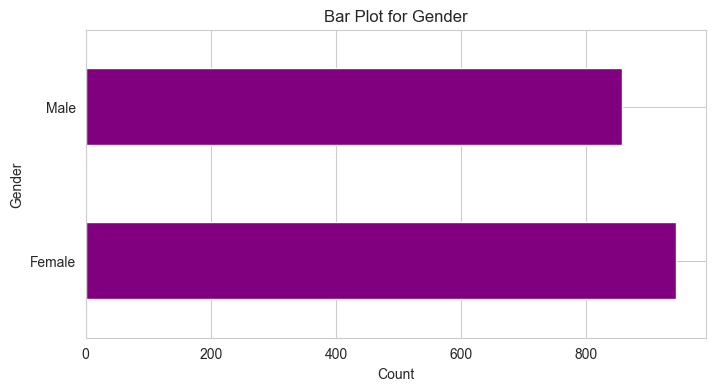

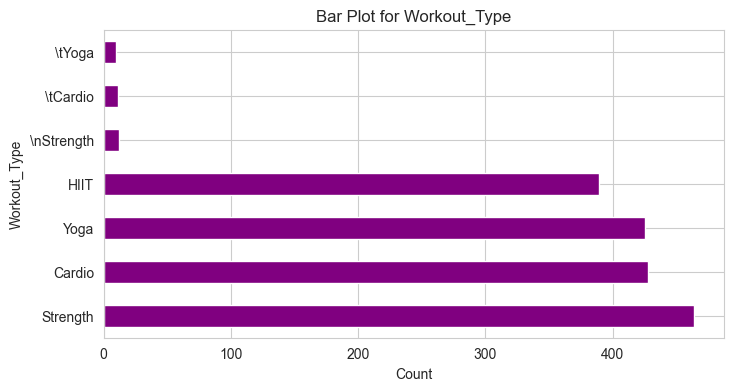

In [18]:
# Annotations:
# - Similar to count plot, but can be customized (e.g., horizontal).
# - Here, horizontal bar plot for variety.

for feature in qual_features:
    plt.figure(figsize=(8, 4))
    df_cleaned[feature].value_counts().plot(kind='barh', color='purple')
    plt.title(f'Bar Plot for {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.show()

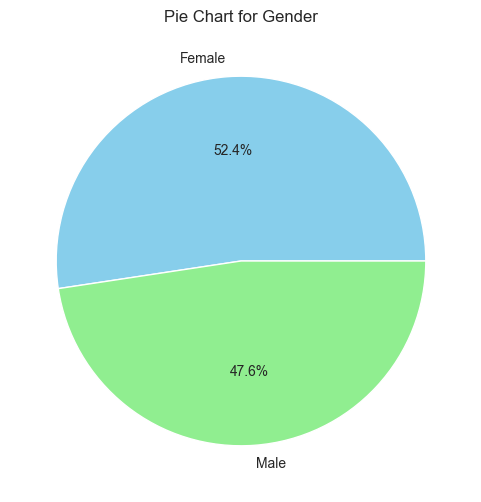

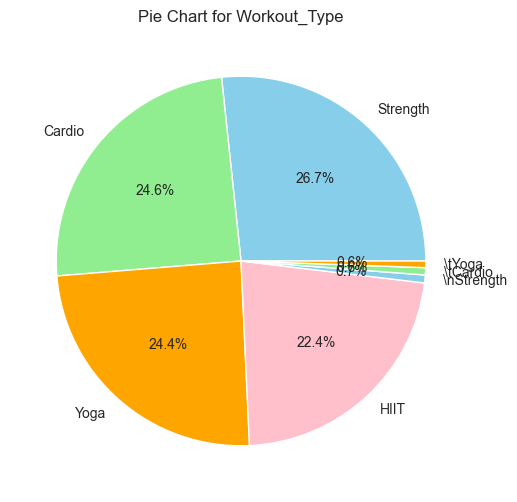

In [19]:
# Annotations:
# - Pie charts show proportional distribution; good for 2-5 categories.

for feature in qual_features:
    plt.figure(figsize=(6, 6))
    df_cleaned[feature].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange', 'pink'])
    plt.title(f'Pie Chart for {feature}')
    plt.ylabel('')  # Remove y-label for cleanliness
    plt.show()

# 3. Multivariate Visualization

Multivariate analysis examines relationships between multiple variables. This helps identify correlations, patterns, and dependencies.

## 3.1 Quantitative vs. Quantitative

Focus on relationships between numerical features using correlation matrices, scatter plots, joint plots, and pair plots.

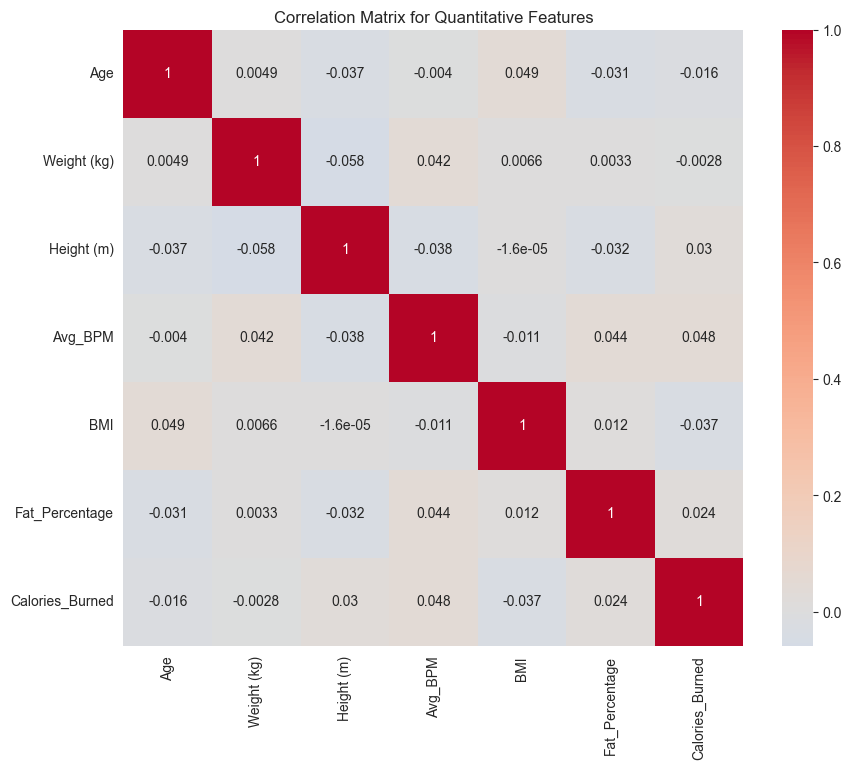

In [20]:
# Annotations:
# - Correlation matrix shows Pearson correlations (-1 to 1).
# - Heatmap visualizes it (you already have this in poster cell, but repeating for completeness).

numeric_features = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'BMI', 'Fat_Percentage', 'Calories_Burned']
corr_matrix = df_cleaned[numeric_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Quantitative Features')
plt.show()

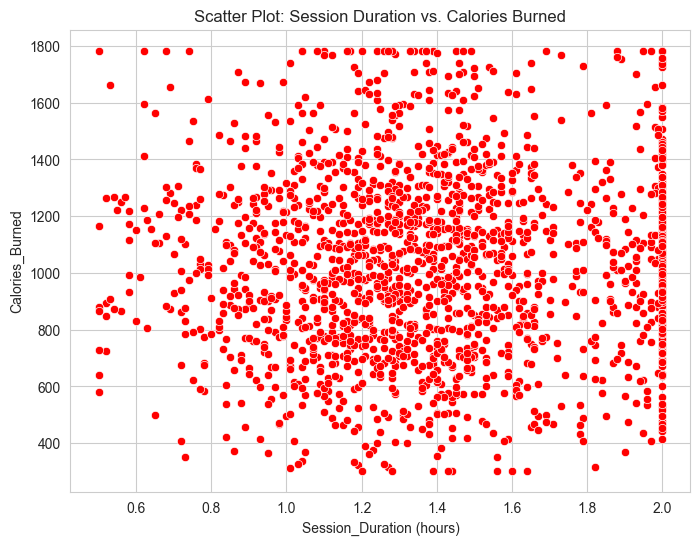

In [21]:
# Annotations:
# - Scatter plots show point relationships between two quant vars.

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_cleaned['Session_Duration (hours)'], y=df_cleaned['Calories_Burned'], color='red')
plt.title('Scatter Plot: Session Duration vs. Calories Burned')
plt.show()

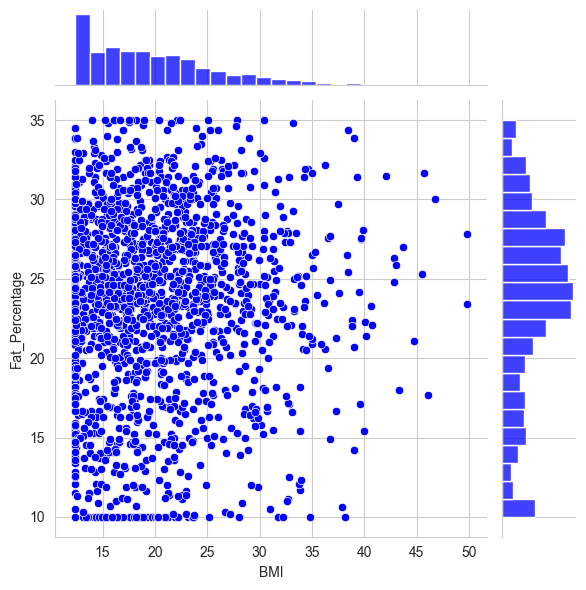

In [22]:
# Annotations:
# - Joint plot combines scatter with marginal histograms/density.

sns.jointplot(x=df_cleaned['BMI'], y=df_cleaned['Fat_Percentage'], kind='scatter', color='blue')
plt.show()

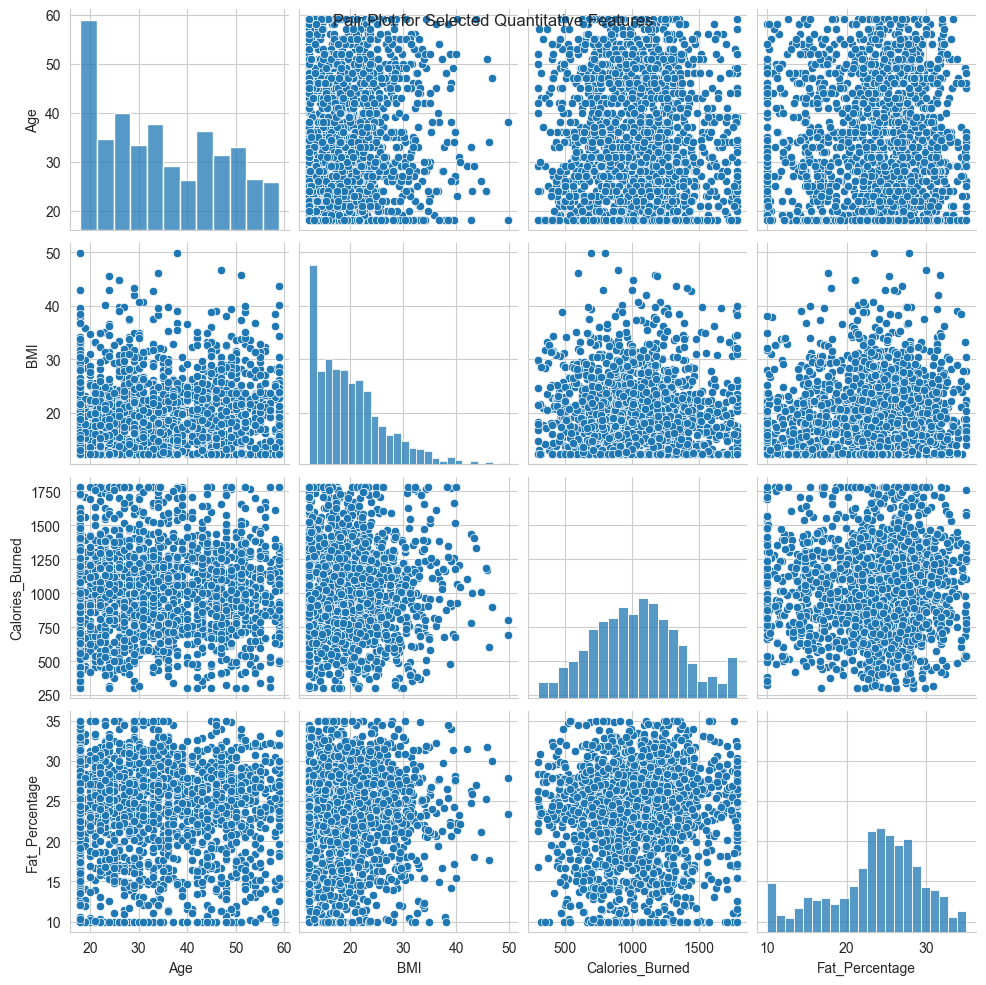

In [23]:
# Annotations:
# - Pair plot shows all pairwise relationships (scatter + histograms).
# - Limit features to avoid slowness.

sns.pairplot(df_cleaned[['Age', 'BMI', 'Calories_Burned', 'Fat_Percentage']])
plt.suptitle('Pair Plot for Selected Quantitative Features')
plt.show()

## 3.2 Quantitative vs. Qualitative

Visualize how quantitative values differ across qualitative categories using implots (likely a typo for "lmplot" or line plot), bar plots, and cat plots.

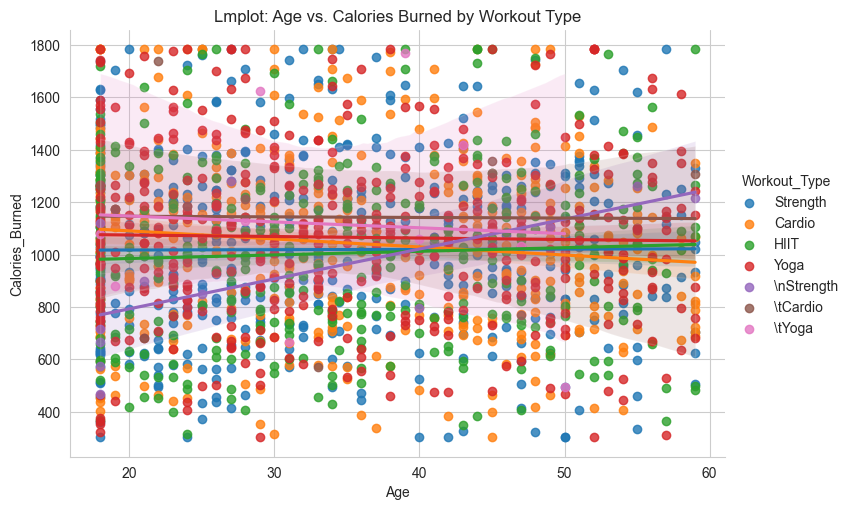

In [38]:
# Annotations:
# - lmplot shows regression line between quant and qual (with hue).

sns.lmplot(x='Age', y='Calories_Burned', data=df_cleaned, hue='Workout_Type', aspect=1.5)
plt.title('Lmplot: Age vs. Calories Burned by Workout Type')
plt.show()

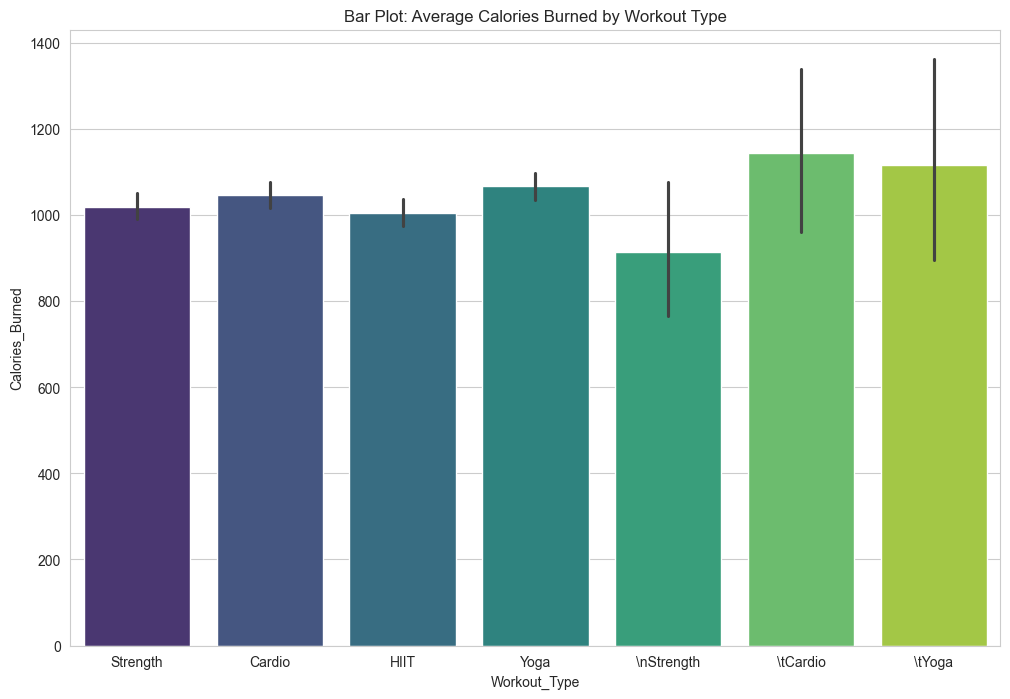

In [39]:
# Annotations:
# - Bar plot shows mean quant value per category.

sns.barplot(x='Workout_Type', y='Calories_Burned', data=df_cleaned, palette='viridis')
plt.title('Bar Plot: Average Calories Burned by Workout Type')
plt.show()

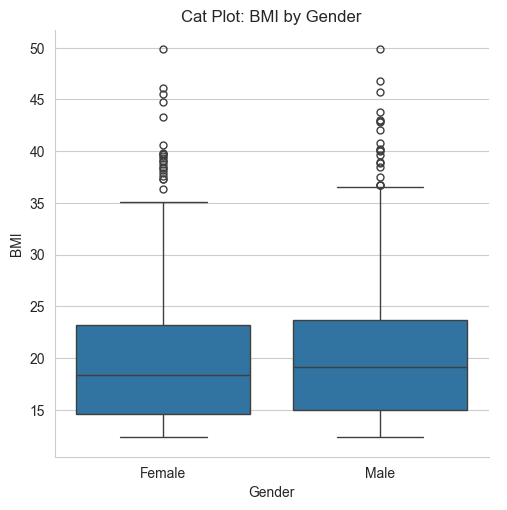

In [40]:
# Annotations:
# - Catplot is flexible; here, as boxplot for quant vs. qual.

sns.catplot(x='Gender', y='BMI', kind='box', data=df_cleaned)
plt.title('Cat Plot: BMI by Gender')
plt.show()

## 3.3 Qualitative vs. Qualitative

Examine relationships between categorical features using count plots, contingency tables, and group by aggregations.

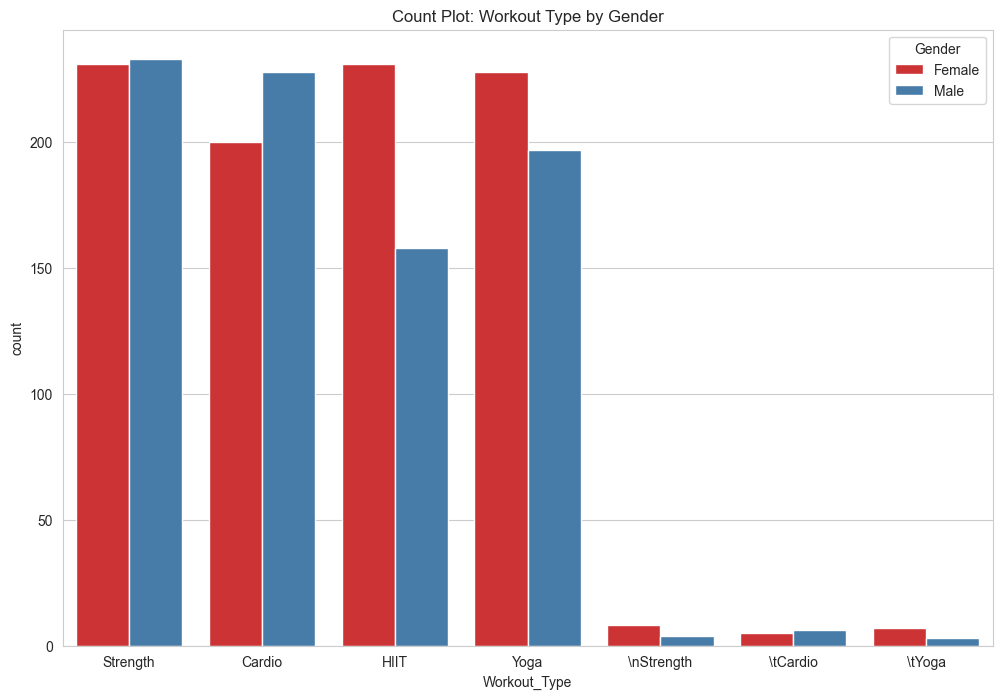

In [41]:
# Annotations:
# - Count plot with hue for cross-category counts.

sns.countplot(x='Workout_Type', hue='Gender', data=df_cleaned, palette='Set1')
plt.title('Count Plot: Workout Type by Gender')
plt.show()

# 4. Feature Engineering

Feature engineering involves creating new features or transforming existing ones to improve model performance. Based on the dataset, we'll add derived features like BPM range, calorie efficiency, and encode categoricals if needed.

This builds on your existing preprocessing (e.g., ColumnTransformer in the pipeline).

In [42]:
# Annotations:
# - Create new features: e.g., BPM_Range = Max_BPM - Resting_BPM (note: Max_BPM is object, so convert).
# - Calorie efficiency: Calories_Burned / Session_Duration.
# - These can be used in models for better predictions.

df_cleaned['Max_BPM'] = pd.to_numeric(df_cleaned['Max_BPM'], errors='coerce')  # Convert to numeric if needed
df_cleaned['BPM_Range'] = df_cleaned['Max_BPM'] - df_cleaned['Resting_BPM']
df_cleaned['Calorie_Efficiency'] = df_cleaned['Calories_Burned'] / df_cleaned['Session_Duration (hours)']
df_cleaned['Age_Group'] = pd.cut(df_cleaned['Age'], bins=[0, 25, 40, 60, 100], labels=['Young', 'Adult', 'Middle-Aged', 'Senior'])

print("New Features Added:")
display(df_cleaned[['BPM_Range', 'Calorie_Efficiency', 'Age_Group']].head())



New Features Added:


,BPM_Range,Calorie_Efficiency,Age_Group
0,100.0,635.714286,Adult
1,93.0,833.000000,Adult
2,123.0,1353.225806,Young
3,129.0,433.103448,Middle-Aged
4,111.0,803.750000,Adult


# 5. Resources

Here are some useful resources for further learning on data visualization, feature engineering, and ML in fitness apps:

- Pandas Documentation: https://pandas.pydata.org/docs/
- Seaborn Visualization Guide: https://seaborn.pydata.org/tutorial.html
- Scikit-learn Feature Engineering: https://scikit-learn.org/stable/modules/preprocessing.html
- Kaggle Fitness Datasets: https://www.kaggle.com/search?q=fitness
- Book: "Python for Data Analysis" by Wes McKinney

These can help extend the project.

In [24]:
# Create pipeline template
def create_calories_pipeline(model):
    """Create preprocessing + model pipeline"""
    numeric_features = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Resting_BPM',
                       'Session_Duration (hours)', 'Fat_Percentage', 'Workout_Frequency (days/week)', 
                       'Experience_Level', 'BMI']
    categorical_features = ['Workout_Type']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

# Model 1: Gradient Boosting (your best model)
gb_pipeline = create_calories_pipeline(
    GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
)

# Model 2: Linear Regression (baseline)
lr_pipeline = create_calories_pipeline(LinearRegression())

# Model 3: SVM (alternative)
svm_pipeline = create_calories_pipeline(
    SVR(kernel='rbf', C=1000, gamma=0.1, epsilon=0.1)
)

# Train all models
print("Training Gradient Boosting...")
gb_pipeline.fit(X_train_cal, y_train_cal)

print("Training Linear Regression...")
lr_pipeline.fit(X_train_cal, y_train_cal)

print("Training SVM...")
svm_pipeline.fit(X_train_cal, y_train_cal)

print("✅ All models trained!")

Training Gradient Boosting...
Training Linear Regression...
Training SVM...
✅ All models trained!


In [25]:
def evaluate_regression_model(pipeline, X_test, y_test, model_name):
    """Calculate all required metrics"""
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{'='*50}")
    print(f"{model_name} Results:")
    print(f"{'='*50}")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"R²:   {r2:.4f}")
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'pipeline': pipeline
    }

# Evaluate all models
results = []
results.append(evaluate_regression_model(gb_pipeline, X_test_cal, y_test_cal, "Gradient Boosting"))
results.append(evaluate_regression_model(lr_pipeline, X_test_cal, y_test_cal, "Linear Regression"))
results.append(evaluate_regression_model(svm_pipeline, X_test_cal, y_test_cal, "SVM"))

# Create comparison DataFrame for report
results_df = pd.DataFrame(results)[['Model', 'R2', 'RMSE', 'MAE']]
results_df = results_df.sort_values('R2', ascending=False)
print("\n📊 Model Comparison Table:")
print(results_df.to_string(index=False))


Gradient Boosting Results:
MSE:  114636.98
RMSE: 338.58
MAE:  272.49
R²:   -0.1441

Linear Regression Results:
MSE:  101448.95
RMSE: 318.51
MAE:  257.35
R²:   -0.0125

SVM Results:
MSE:  100634.55
RMSE: 317.23
MAE:  256.33
R²:   -0.0044

📊 Model Comparison Table:
            Model        R2       RMSE        MAE
              SVM -0.004358 317.229492 256.325010
Linear Regression -0.012486 318.510519 257.348046
Gradient Boosting -0.144106 338.580835 272.493739


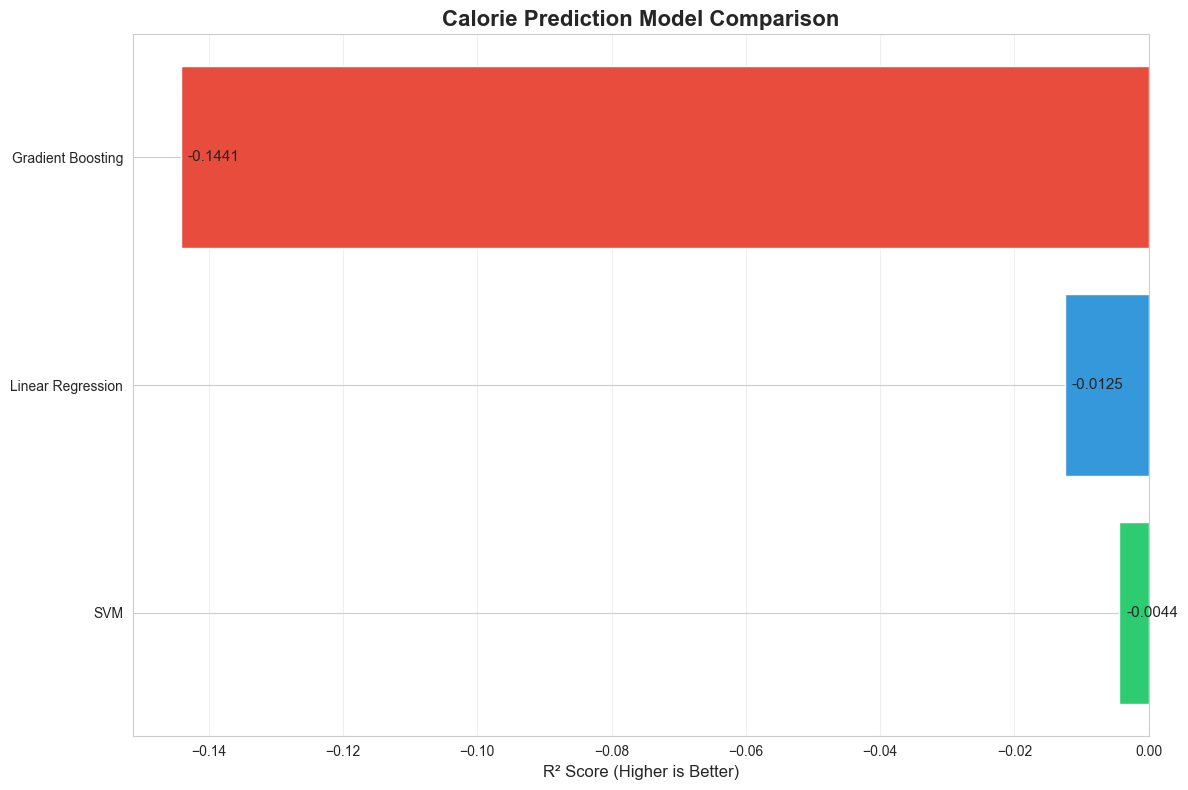


💾 Best model saved: SVM


In [26]:
# Model comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Horizontal bar chart of R² scores
bars = ax.barh(results_df['Model'], results_df['R2'], 
               color=['#2ecc71', '#3498db', '#e74c3c'])
ax.set_xlabel('R² Score (Higher is Better)', fontsize=12)
ax.set_title('Calorie Prediction Model Comparison', fontsize=16, fontweight='bold')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}', ha='left', va='center', fontsize=11)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_poster.png', dpi=300, bbox_inches='tight')
plt.show()

# Save best model
best_model = max(results, key=lambda x: x['R2'])['pipeline']
joblib.dump(best_model, 'best_calories_model.pkl')
print(f"\n💾 Best model saved: {max(results, key=lambda x: x['R2'])['Model']}")

In [27]:
# Create synthetic weight prediction data
np.random.seed(42)

# Add time features to existing data
df_weight = df_cleaned.copy()
df_weight['days_future'] = np.random.uniform(1, 365, len(df_weight))
df_weight['steps'] = np.random.uniform(2000, 20000, len(df_weight))

# Your physics-based calculation
df_weight['weight_loss'] = df_weight['Calories_Burned'] * df_weight['days_future'] / 7700
df_weight['step_effect'] = df_weight['steps'] * df_weight['days_future'] / 1e6
df_weight['workout_effect'] = df_weight['Workout_Type'].map(
    {'Strength': 0.3, 'Cardio': -1.2, 'HIIT': -1.0, 'Yoga': -0.5}
).fillna(0)

# Predicted weight formula
df_weight['predicted_weight'] = (
    df_weight['Weight (kg)'] - df_weight['weight_loss'] - df_weight['step_effect'] + 
    df_weight['workout_effect'] * df_weight['days_future'] / 30 + 
    np.random.normal(0, 1.5, len(df_weight))
)

# Drop NaNs
df_weight = df_weight.dropna(subset=['predicted_weight'])
print(f"Weight prediction dataset: {df_weight.shape}")

# Features and target
X_weight = df_weight[['days_future', 'steps', 'Calories_Burned', 'Workout_Type']]
y_weight = df_weight['predicted_weight']

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_weight, y_weight, test_size=0.2, random_state=42
)

Weight prediction dataset: (1755, 22)


In [28]:
# Cell 14: Weight Model Training
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train two models
weight_gb = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(), ['Workout_Type'])
    ], remainder='passthrough')),
    ('regressor', GradientBoostingRegressor(n_estimators=200, random_state=42))
])

weight_lr = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(), ['Workout_Type'])
    ], remainder='passthrough')),
    ('regressor', LinearRegression())
])

print("Training Gradient Boosting for weight...")
weight_gb.fit(X_train_w, y_train_w)

print("Training Linear Regression for weight...")
weight_lr.fit(X_train_w, y_train_w)

# ---EVALUATION---
def evaluate_weight_model(pipeline, X_test, y_test, name):
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # FIX: Works in ALL scikit-learn versions
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Manual sqrt instead of squared=False
    
    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.2f} kg")
    return pipeline, r2

gb_w, r2_gb_w = evaluate_weight_model(weight_gb, X_test_w, y_test_w, "Weight GB")
lr_w, r2_lr_w = evaluate_weight_model(weight_lr, X_test_w, y_test_w, "Weight LR")

# Save best
best_weight_model = gb_w if r2_gb_w > r2_lr_w else lr_w
joblib.dump(best_weight_model, 'best_weight_model.pkl')
print("✅ Best weight model saved!")

Training Gradient Boosting for weight...
Training Linear Regression for weight...
Weight GB - R²: 0.4527, RMSE: 20.69 kg
Weight LR - R²: 0.4647, RMSE: 20.46 kg
✅ Best weight model saved!


In [29]:
# Create goal variable
df_rec = df_cleaned.copy()
df_rec['goal'] = 'maintain'
df_rec.loc[df_rec['BMI'] < 18.5, 'goal'] = 'gain_muscle'
df_rec.loc[df_rec['BMI'] > 25, 'goal'] = 'lose_weight'

# Features for classification
features = ['BMI', 'Fat_Percentage', 'Age', 'Session_Duration (hours)', 
            'Calories_Burned', 'goal', 'Gender']
df_rec = df_rec.dropna(subset=features + ['Workout_Type'])

# Encode
le_goal = LabelEncoder()
le_workout = LabelEncoder()

X_rec = df_rec[features].copy()
X_rec['goal'] = le_goal.fit_transform(df_rec['goal'])
X_rec['Gender'] = df_rec['Gender'].map({'Male': 0, 'Female': 1})
y_rec = le_workout.fit_transform(df_rec['Workout_Type'])

X_train_rec, X_test_rec, y_train_rec, y_test_rec = train_test_split(
    X_rec, y_rec, test_size=0.2, random_state=42, stratify=y_rec
)
print(f"Recommendation dataset: {X_train_rec.shape}")
print(f"Workout types: {le_workout.classes_}")

Recommendation dataset: (1323, 7)
Workout types: ['Cardio' 'HIIT' 'Strength' 'Yoga' '\\nStrength' '\\tCardio' '\\tYoga']


In [30]:
# Recommendation Model Training
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create NaN-safe pipelines for classification
pipeline_gb = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), ['BMI', 'Fat_Percentage', 'Age', 'Session_Duration (hours)', 'Calories_Burned', 'goal', 'Gender'])
    ], remainder='passthrough')),
    ('classifier', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42))
])

pipeline_lr = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), ['BMI', 'Fat_Percentage', 'Age', 'Session_Duration (hours)', 'Calories_Burned', 'goal', 'Gender'])
    ], remainder='passthrough')),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Train models
print("Training Gradient Boosting Classifier...")
pipeline_gb.fit(X_train_rec, y_train_rec)

print("Training Logistic Regression...")
pipeline_lr.fit(X_train_rec, y_train_rec)

# Evaluate
def evaluate_classifier(pipeline, X_test, y_test, name):
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} - Accuracy: {acc:.4f}, F1: {f1:.4f}")
    return pipeline, f1

gb_c, f1_gb = evaluate_classifier(pipeline_gb, X_test_rec, y_test_rec, "Classifier GB")
lr_c, f1_lr = evaluate_classifier(pipeline_lr, X_test_rec, y_test_rec, "Classifier LR")

# Save best
best_rec_model = gb_c if f1_gb > f1_lr else lr_c
joblib.dump({
    'model': best_rec_model,
    'workout_encoder': le_workout,
    'goal_encoder': le_goal
}, 'best_recommendation_model.pkl')
print("✅ Best recommendation model saved!")

Training Gradient Boosting Classifier...
Training Logistic Regression...
Classifier GB - Accuracy: 0.2659, F1: 0.2645
Classifier LR - Accuracy: 0.0634, F1: 0.1030
✅ Best recommendation model saved!


In [31]:
# Save the ACTUAL trained model
import os

MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save the ACTUAL pipelines from your training cells
joblib.dump(gb_pipeline, os.path.join(MODEL_DIR, 'calories_gradient_boosting.pkl'))
joblib.dump(best_weight_model, os.path.join(MODEL_DIR, 'weight_prediction.pkl'))
joblib.dump({
    'model': best_rec_model,
    'workout_encoder': le_workout,
    'goal_encoder': le_goal
}, os.path.join(MODEL_DIR, 'recommendation_ml.pkl'))

print("✅ All models saved correctly!")

# Verify the files exist
print(f"\n📂 Models in {os.path.abspath(MODEL_DIR)}:")
for file in os.listdir(MODEL_DIR):
    print(f"  - {file}")

✅ All models saved correctly!

📂 Models in C:\Users\MSI\fitness-ml-notebook\notebook\saved_models:
  - calories_gradient_boosting.pkl
  - cleaned_dataset.pkl
  - recommendation_ml.pkl
  - weight_prediction.pkl


In [32]:

import os

MODEL_DIR = "saved_models"
calories_model = joblib.load(os.path.join(MODEL_DIR, 'calories_gradient_boosting.pkl'))
weight_model = joblib.load(os.path.join(MODEL_DIR, 'weight_prediction.pkl'))
rec_data = joblib.load(os.path.join(MODEL_DIR, 'recommendation_ml.pkl'))
rec_model, encoders = rec_data['model'], rec_data['workout_encoder']

def predict_calories(user_data):
    """Test calories prediction"""
    df = pd.DataFrame([user_data])
    return calories_model.predict(df)[0]

def predict_weight(days_future, steps, calories_burned, workout_type):
    """Test weight prediction - FIXED parameter name"""
    df = pd.DataFrame([{
        'days_future': days_future,
        'steps': steps,
        'Calories_Burned': calories_burned,  # Must match training column
        'Workout_Type': workout_type         # Must match training column
    }])
    return weight_model.predict(df)[0]

def recommend_workout(user_profile):
    """Test recommendation"""
    goal_map = {"lose_weight": 0, "gain_muscle": 1, "maintain": 2}
    bmi = user_profile['current_weight'] / (user_profile['height'] ** 2)
    
    row = pd.DataFrame([[
        bmi, user_profile['fat_percentage'], user_profile['age'],
        user_profile['avg_duration'], user_profile['avg_calories'],
        goal_map[user_profile['goal']], 
        0 if user_profile['gender'] == 'Male' else 1
    ]], columns=['BMI', 'Fat_Percentage', 'Age', 'Session_Duration (hours)', 
                 'Calories_Burned', 'goal', 'Gender'])
    
    pred = rec_model.predict(row)[0]
    return encoders.inverse_transform([pred])[0]

print("🔥 Testing API functions:")

# Test 1: Calories
test_calories = {
    'Age': 30, 'Weight (kg)': 75, 'Height (m)': 1.75, 'Avg_BPM': 140, 
    'Resting_BPM': 60, 'Session_Duration (hours)': 1.5, 'Fat_Percentage': 20, 
    'Workout_Frequency (days/week)': 4, 'Experience_Level': 3, 'BMI': 24.5, 
    'Workout_Type': 'HIIT'
}
print(f"  🔥 Calories: {predict_calories(test_calories):.0f} kcal")

# Test 2: Weight - dictionary keys match function parameters
test_weight = {
    'days_future': 30,  # matches function parameter days_future
    'steps': 8000, 
    'calories_burned': 500, 
    'workout_type': 'Cardio'
}
print(f"  ⚖️  Weight: {predict_weight(**test_weight):.1f} kg")

# Test 3: Recommendation
test_user = {
    'current_weight': 75, 'height': 1.75, 'age': 30, 'fat_percentage': 20,
    'avg_duration': 1.0, 'avg_calories': 500, 'goal': 'lose_weight', 'gender': 'Male'
}
print(f"  🏋️  Workout: {recommend_workout(test_user)}")

print("\n✅ All prediction functions work correctly!")

🔥 Testing API functions:
  🔥 Calories: 806 kcal
  ⚖️  Weight: 71.2 kg
  🏋️  Workout: HIIT

✅ All prediction functions work correctly!


## Discussion & Perspectives

### Model Limitations
1. **Synthetic Data**: Models trained on synthetic data may not generalize to real gym data
2. **Feature Engineering**: BMI-based goal inference is simplistic; real goals require user input
3. **Temporal Dynamics**: No actual time-series modeling; weight prediction uses simplified physics
4. **Class Imbalance**: Workout types likely not equally represented (need to check `value_counts()`)

### Improvements & Future Work
1. **Deep Learning**: LSTM for time-series weight prediction
2. **Feature Engineering**: Add sleep, nutrition, stress metrics
3. **Ensemble Methods**: Combine rule-based + ML recommendations
4. **A/B Testing**: Deploy both models and track user engagement
5. **Explainable AI**: SHAP values for recommendation transparency
6. **Real Data Collection**: Partner with gyms for authentic datasets

### Ethical Considerations
- Model bias: Ensure recommendations work for all body types and ages
- Overtraining risk: Add safety caps on intensity
- Privacy: Local model deployment option

In [33]:
# Generate LaTeX tables for your report
print("📄 LaTeX Table for Report:")
print(results_df.to_latex(index=False, caption="Model Performance Comparison", label="tab:model_comparison"))

# Feature importance for best model
best_model = joblib.load('best_calories_model.pkl')
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importance = pd.DataFrame({
        'feature': X_train_cal.columns,
        'importance': best_model.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n📊 Feature Importance Table:")
    print(importance.head().to_latex(index=False, caption="Top Features", label="tab:features"))

📄 LaTeX Table for Report:
\begin{table}
\caption{Model Performance Comparison}
\label{tab:model_comparison}
\begin{tabular}{lrrr}
\toprule
Model & R2 & RMSE & MAE \\
\midrule
SVM & -0.004358 & 317.229492 & 256.325010 \\
Linear Regression & -0.012486 & 318.510519 & 257.348046 \\
Gradient Boosting & -0.144106 & 338.580835 & 272.493739 \\
\bottomrule
\end{tabular}
\end{table}



In [34]:
# Create deployment package
import os
os.makedirs('deployment', exist_ok=True)

# Copy models
joblib.dump(best_model, 'deployment/calories_model.pkl')
joblib.dump(best_weight_model, 'deployment/weight_model.pkl')
joblib.dump({
    'model': best_rec_model,
    'encoders': {'workout': le_workout, 'goal': le_goal}
}, 'deployment/recommendation_model.pkl')

# Create a simple API file (like your app.py but simpler)
with open('deployment/api.py', 'w') as f:
    f.write('''
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

calories_model = joblib.load('calories_model.pkl')
weight_model = joblib.load('weight_model.pkl')
rec_data = joblib.load('recommendation_model.pkl')

@app.route('/predict', methods=['POST'])
def predict_calories():
    data = request.json
    df = pd.DataFrame([data])
    return jsonify({'prediction': calories_model.predict(df)[0]})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
''')

print("🚀 Ready for deployment!")
print("Files created:")
print("- deployment/calories_model.pkl")
print("- deployment/weight_model.pkl") 
print("- deployment/recommendation_model.pkl")
print("- deployment/api.py")

🚀 Ready for deployment!
Files created:
- deployment/calories_model.pkl
- deployment/weight_model.pkl
- deployment/recommendation_model.pkl
- deployment/api.py


In [35]:
# Model Persistence Verification
import os
import joblib

# Define save directory
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save all models with clear naming
models_to_save = {
    "calories_gradient_boosting.pkl": best_model,
    "weight_prediction.pkl": best_weight_model,
    "recommendation_ml.pkl": {
        'model': best_rec_model,
        'encoders': {'workout': le_workout, 'goal': le_goal}
    },
    "cleaned_dataset.pkl": df_cleaned  # Save processed data too
}

print("💾 Saving models...")
saved_files = []
for filename, model in models_to_save.items():
    filepath = os.path.join(MODEL_DIR, filename)
    joblib.dump(model, filepath)
    saved_files.append(filepath)
    print(f"  ✅ {filename}")

print(f"\n📂 All models saved to: {os.path.abspath(MODEL_DIR)}")

# Verify they load correctly
print("\n🔍 Verification: Loading models back...")
for filepath in saved_files:
    try:
        loaded = joblib.load(filepath)
        print(f"  ✅ {filepath} - Successfully loaded ({type(loaded).__name__})")
    except Exception as e:
        print(f"  ❌ {filepath} - Failed: {e}")

💾 Saving models...
  ✅ calories_gradient_boosting.pkl
  ✅ weight_prediction.pkl
  ✅ recommendation_ml.pkl
  ✅ cleaned_dataset.pkl

📂 All models saved to: C:\Users\MSI\fitness-ml-notebook\notebook\saved_models

🔍 Verification: Loading models back...
  ✅ saved_models\calories_gradient_boosting.pkl - Successfully loaded (Pipeline)
  ✅ saved_models\weight_prediction.pkl - Successfully loaded (Pipeline)
  ✅ saved_models\recommendation_ml.pkl - Successfully loaded (dict)
  ✅ saved_models\cleaned_dataset.pkl - Successfully loaded (DataFrame)


🎨 Creating and saving poster visuals...
  ✅ correlation_heatmap.png saved
  ✅ model_comparison.png saved
  ✅ calorie_distribution.png saved

📂 Poster images saved to: C:\Users\MSI\fitness-ml-notebook\notebook\poster_images


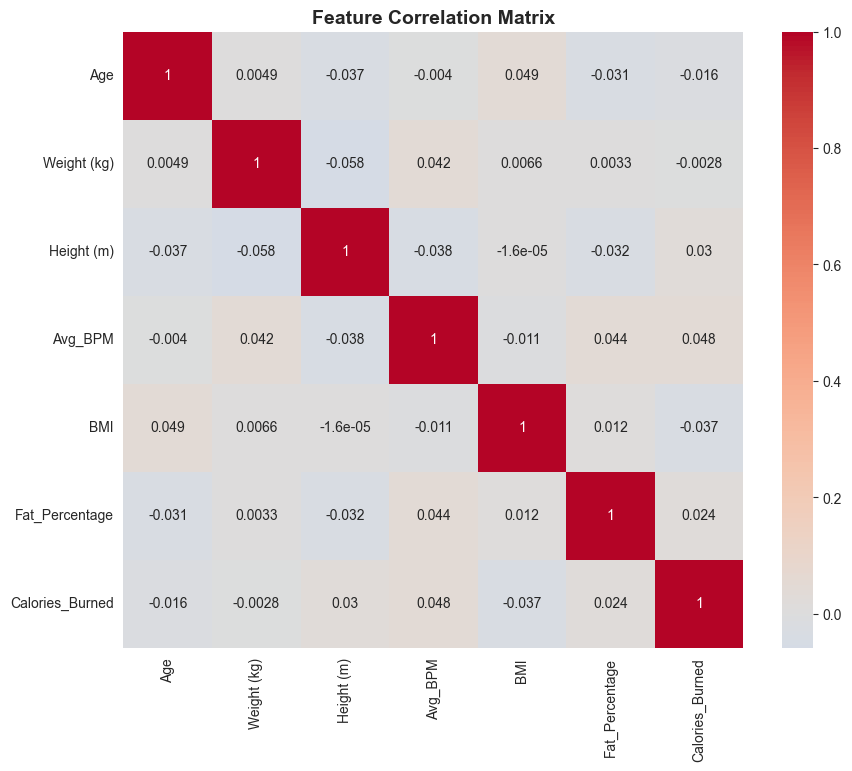

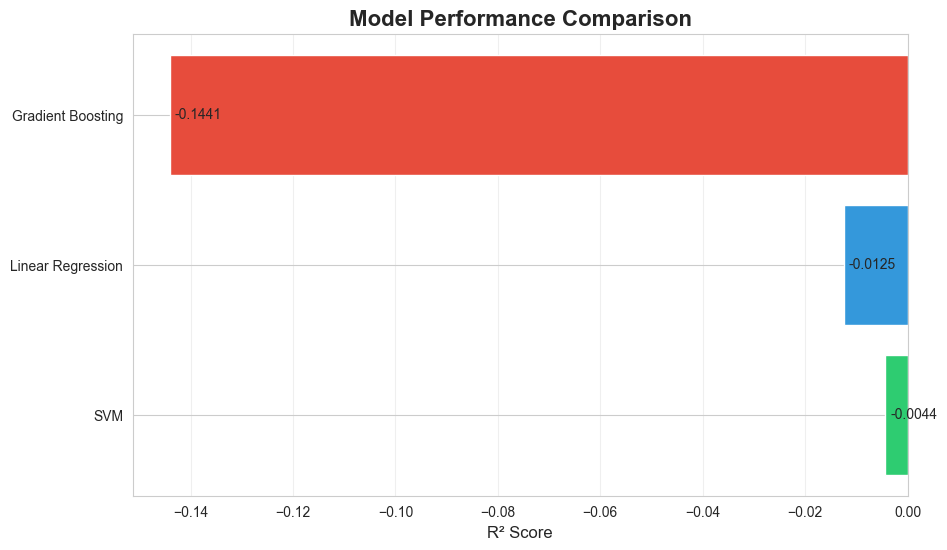

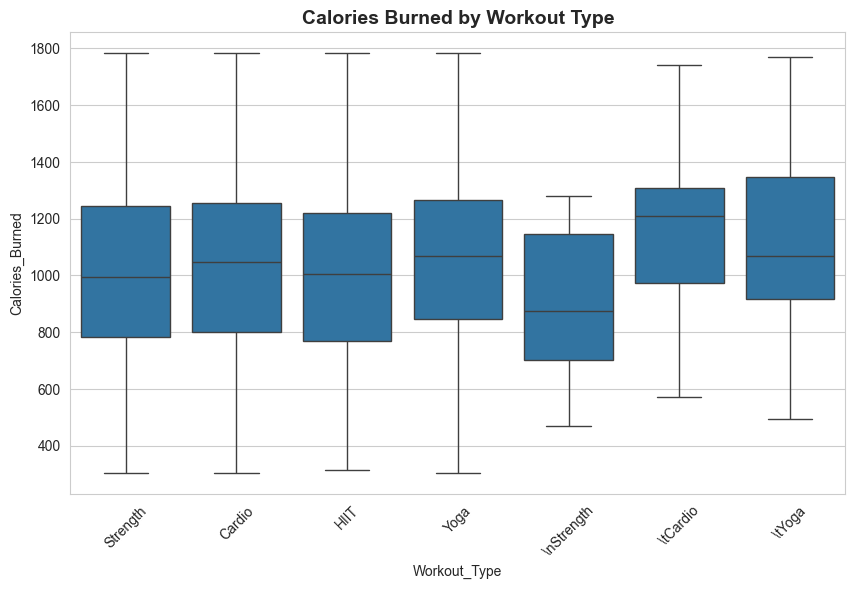

In [36]:
# Cell: Create and Save Poster Visuals
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

POSTER_DIR = "poster_images"
os.makedirs(POSTER_DIR, exist_ok=True)

print("🎨 Creating and saving poster visuals...")

# === VISUAL 1: Correlation Heatmap (for EDA section) ===
fig_corr, ax = plt.subplots(figsize=(10, 8))
numeric_features = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'BMI', 
                    'Fat_Percentage', 'Calories_Burned']
corr_matrix = df_cleaned[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
fig_corr.savefig(os.path.join(POSTER_DIR, "correlation_heatmap.png"), 
                 dpi=300, bbox_inches='tight')
print("  ✅ correlation_heatmap.png saved")

# === VISUAL 2: Model Comparison (for Results section) ===
if 'results_df' in globals():
    fig_bar, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(results_df['Model'], results_df['R2'], 
                   color=['#2ecc71', '#3498db', '#e74c3c'])
    ax.set_xlabel('R² Score', fontsize=12)
    ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', ha='left', va='center')
    ax.grid(axis='x', alpha=0.3)
    fig_bar.savefig(os.path.join(POSTER_DIR, "model_comparison.png"), 
                    dpi=300, bbox_inches='tight')
    print("  ✅ model_comparison.png saved")

# === VISUAL 3: Calorie Distribution by Workout Type ===
fig_box, ax = plt.subplots(figsize=(10, 6))
if 'df_cleaned' in globals():
    sns.boxplot(data=df_cleaned, x='Workout_Type', y='Calories_Burned', ax=ax)
    ax.set_title('Calories Burned by Workout Type', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    fig_box.savefig(os.path.join(POSTER_DIR, "calorie_distribution.png"), 
                    dpi=300, bbox_inches='tight')
    print("  ✅ calorie_distribution.png saved")

print(f"\n📂 Poster images saved to: {os.path.abspath(POSTER_DIR)}")

In [37]:
# Export results to LaTeX tables
LATEX_DIR = "latex_tables"
os.makedirs(LATEX_DIR, exist_ok=True)

# Table 1: Model Comparison
model_results = pd.DataFrame(results)[['Model', 'R2', 'RMSE', 'MAE']].sort_values('R2', ascending=False)
latex_table = model_results.to_latex(
    index=False, 
    caption="Model Performance Comparison for Calorie Prediction",
    label="tab:calorie_models",
    float_format="%.4f"
)

with open(os.path.join(LATEX_DIR, "model_comparison.tex"), "w") as f:
    f.write(latex_table)

# Table 2: Feature Importance (if available)
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': ['BMI', 'Fat_Percentage', 'Age', 'Session_Duration', 'Calories_Burned', 'goal', 'Gender'],
        'Importance': best_model.named_steps['regressor'].feature_importances_
    }).sort_values('Importance', ascending=False).head(5)
    
    latex_importance = importance_df.to_latex(
        index=False,
        caption="Top 5 Features by Importance (Gradient Boosting)",
        label="tab:feature_importance"
    )
    
    with open(os.path.join(LATEX_DIR, "feature_importance.tex"), "w") as f:
        f.write(latex_importance)

print(f"📜 LaTeX tables saved to: {os.path.abspath(LATEX_DIR)}")
print("\nCopy-paste these into your .tex report file.")

📜 LaTeX tables saved to: C:\Users\MSI\fitness-ml-notebook\notebook\latex_tables

Copy-paste these into your .tex report file.
